In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'CTC-A.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,3329,-2246,1083,191,643,759,1481,7978,0,...,13630,1817,0,272,4322,2339,8180,183,-403,80.93
1,2014-03-31,2573,-1738,835,76,576,853,1679,8002,0,...,13587,1779,0,272,4191,2337,8118,-43,39,80.52
2,2014-06-30,3166,-2153,1013,179,308,534,1555,7385,0,...,13033,1706,0,319,4092,1841,7577,306,21,80.09
3,2014-09-30,3070,-2085,985,178,410,845,1973,8251,0,...,14137,2040,0,321,4542,2394,8591,-173,-261,79.21
4,2014-12-31,3654,-2440,1214,207,662,880,1624,8510,0,...,14553,1961,0,588,4579,2132,8922,-484,-388,78.46


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,58.50,5340,-3322,2018,563,331,1310,3216,...,2342,22102,3201,0,1040,7147,3217,15063,911,-182
37,2023-03-31,2023-04-21,57.43,3707,-2425,1282,43,312,1508,3280,...,2288,22163,2849,0,985,7498,3218,15460,-311,-159
38,2023-06-30,2023-07-21,56.55,4256,-2807,1449,127,433,863,3214,...,2248,21840,2926,0,1545,7704,2659,15283,823,-74
39,2023-09-30,2023-10-21,55.76,4250,-2814,1436,-28,459,1524,3360,...,2256,22713,2990,0,561,6999,3754,16212,-29,-162
40,2023-12-31,2024-02-11,55.76,4443,-2906,1537,197,311,1151,2693,...,2255,21978,2689,0,561,6389,4404,15533,870,-353


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,58.50,5340,-3322,2018,563,331,1310,3216,...,22102,3201,0,1040,7147,3217,15063,911,-182,1.357405
37,2023-03-31,2023-04-21,57.43,3707,-2425,1282,43,312,1508,3280,...,22163,2849,0,985,7498,3218,15460,-311,-159,1.352063
38,2023-06-30,2023-07-21,56.55,4256,-2807,1449,127,433,863,3214,...,21840,2926,0,1545,7704,2659,15283,823,-74,1.343352
39,2023-09-30,2023-10-21,55.76,4250,-2814,1436,-28,459,1524,3360,...,22713,2990,0,561,6999,3754,16212,-29,-162,1.341033
40,2023-12-31,2024-02-11,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,58.50,5340,-3322,2018,563,331,1310,3216,...,22102,3201,0,1040,7147,3217,15063,911,-182,1.357405
37,2023-03-31,2023-04-21,57.43,3707,-2425,1282,43,312,1508,3280,...,22163,2849,0,985,7498,3218,15460,-311,-159,1.352063
38,2023-06-30,2023-07-21,56.55,4256,-2807,1449,127,433,863,3214,...,21840,2926,0,1545,7704,2659,15283,823,-74,1.343352
39,2023-09-30,2023-10-21,55.76,4250,-2814,1436,-28,459,1524,3360,...,22713,2990,0,561,6999,3754,16212,-29,-162,1.341033
40,2023-12-31,2024-02-11,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,74.511681,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,0.399853,0.600147,17.544137,4.944414,20.709176,6.066172,0.325323,0.057375,0.056053,0.140183
1,2014-02-24,76.456612,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,0.399853,0.600147,17.544137,4.944414,20.709176,6.066172,0.325323,0.057375,0.056053,0.140183
2,2014-03-03,76.203934,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,0.399853,0.600147,17.544137,4.944414,20.709176,6.066172,0.325323,0.057375,0.056053,0.140183
3,2014-03-10,76.303474,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,0.399853,0.600147,17.544137,4.944414,20.709176,6.066172,0.325323,0.057375,0.056053,0.140183
4,2014-03-17,77.352493,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,0.399853,0.600147,17.544137,4.944414,20.709176,6.066172,0.325323,0.057375,0.056053,0.140183


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,74.511681,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,6.066172,0.325323,0.057375,0.056053,0.140183,7.892972,1.106464,0.452856,1.018867,2.572624
1,2014-02-24,76.456612,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,6.066172,0.325323,0.057375,0.056053,0.140183,8.098997,1.135346,0.464677,1.030687,2.639775
2,2014-03-03,76.203934,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,6.066172,0.325323,0.057375,0.056053,0.140183,8.072231,1.131593,0.463141,1.029152,2.631051
3,2014-03-10,76.303474,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,6.066172,0.325323,0.057375,0.056053,0.140183,8.082775,1.133072,0.463746,1.029757,2.634488
4,2014-03-17,77.352493,2013-12-31,3329.0,9.440257,67.342148,80.93,2344.0,28.963302,643.0,...,6.066172,0.325323,0.057375,0.056053,0.140183,8.193897,1.148649,0.470121,1.036132,2.670707


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

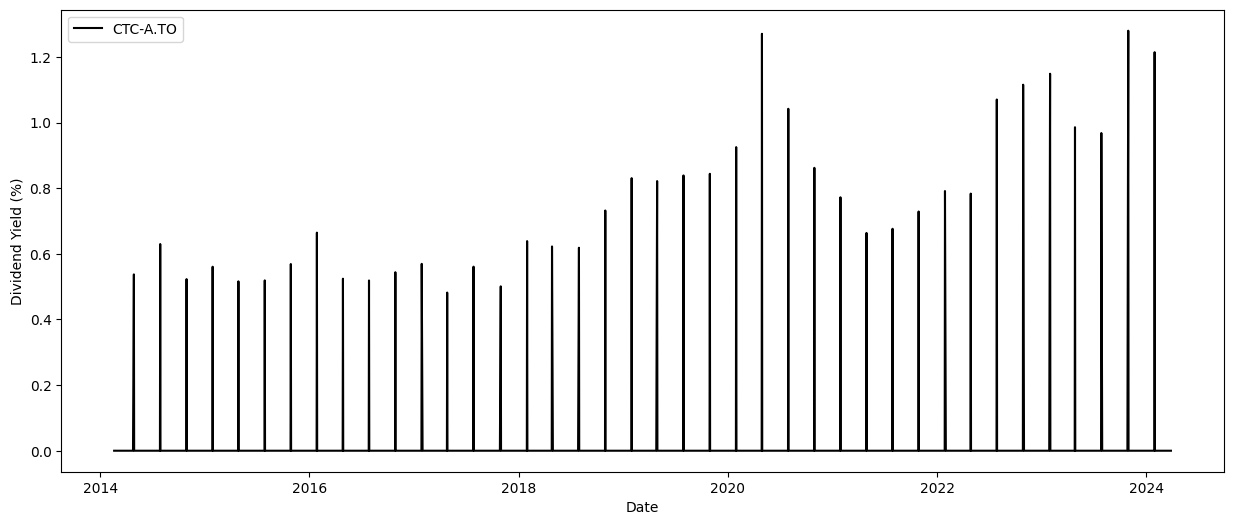

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.219166
share_price      1.000000
Name: share_price, dtype: float64


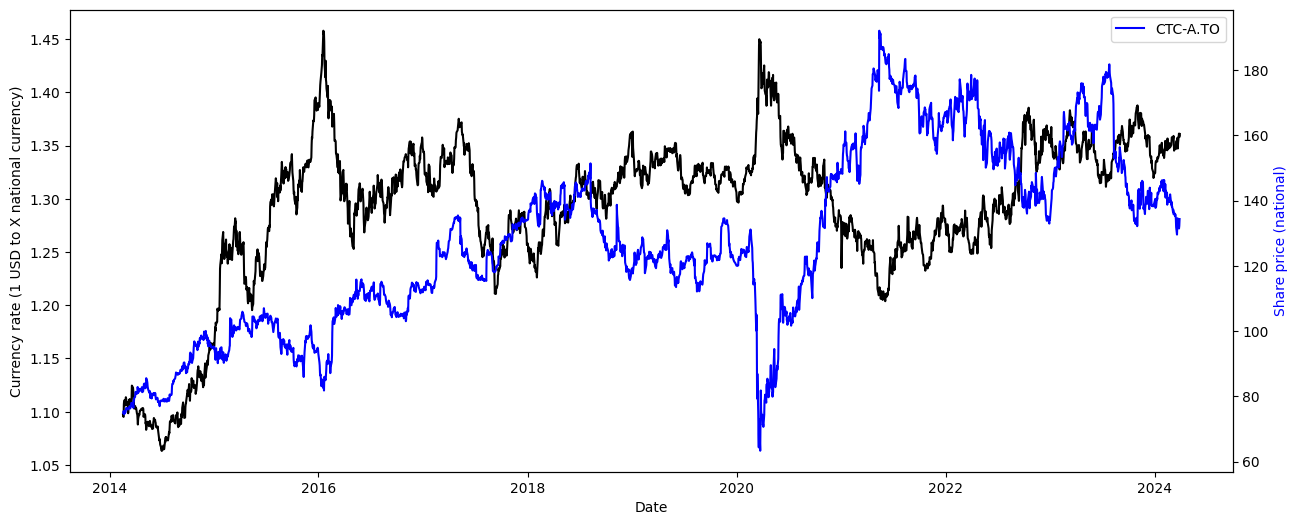

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

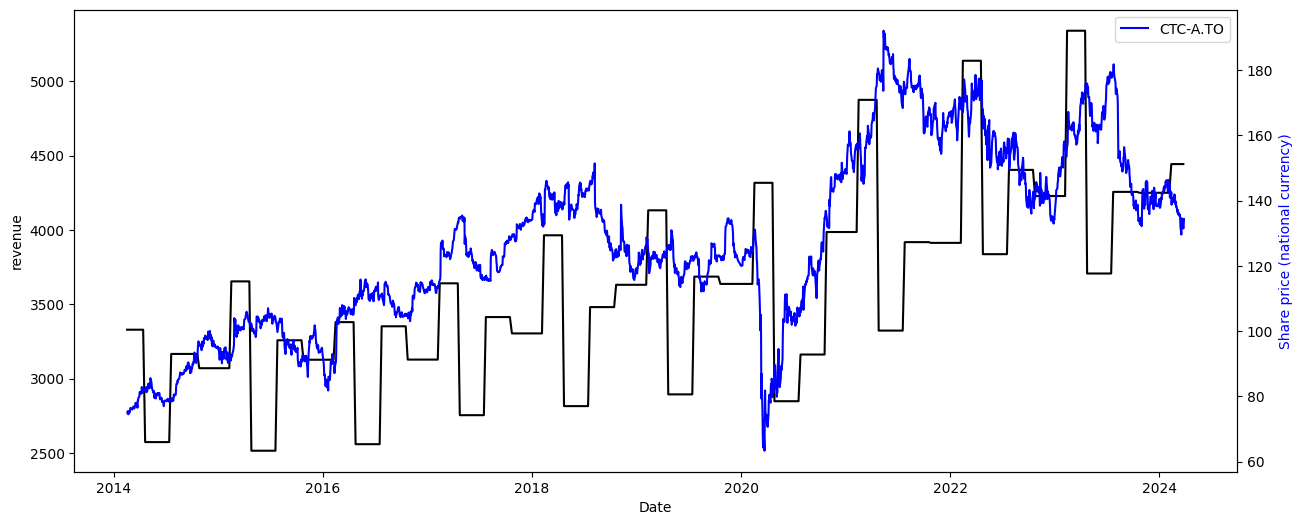

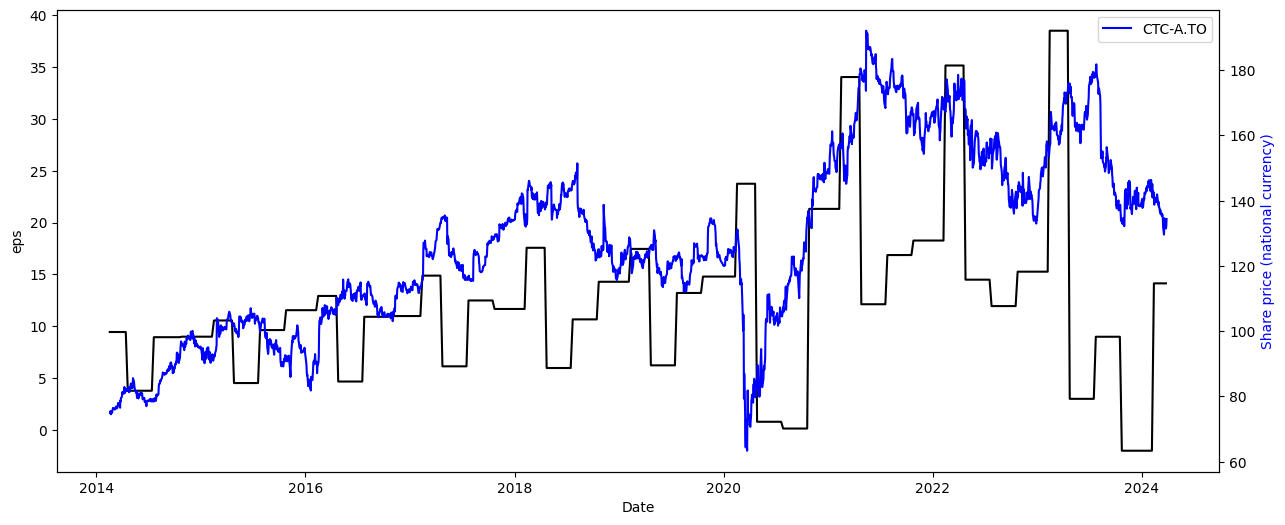

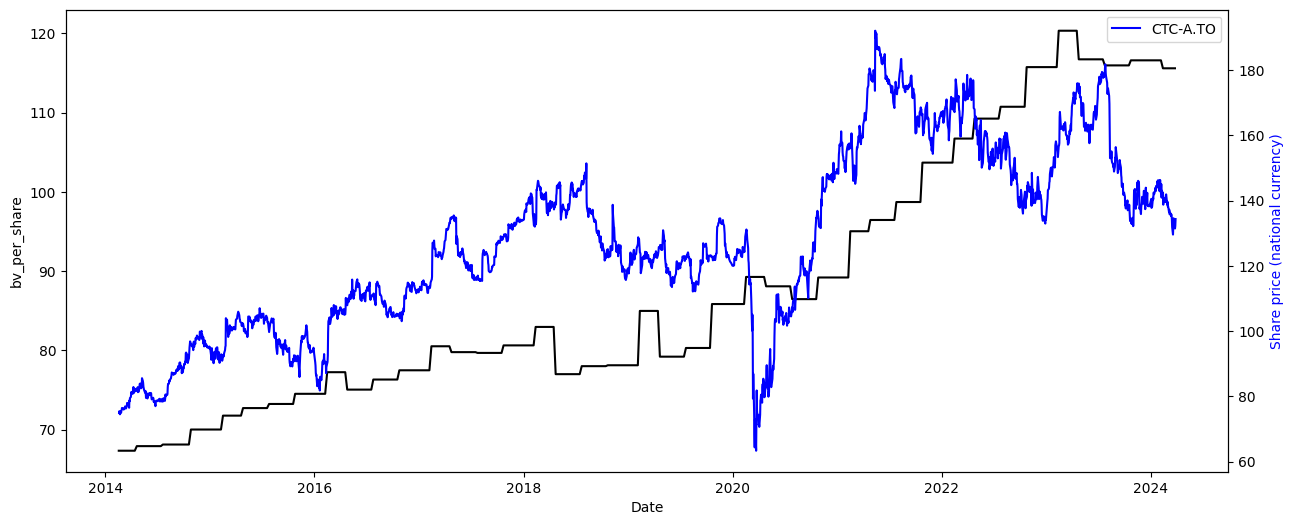

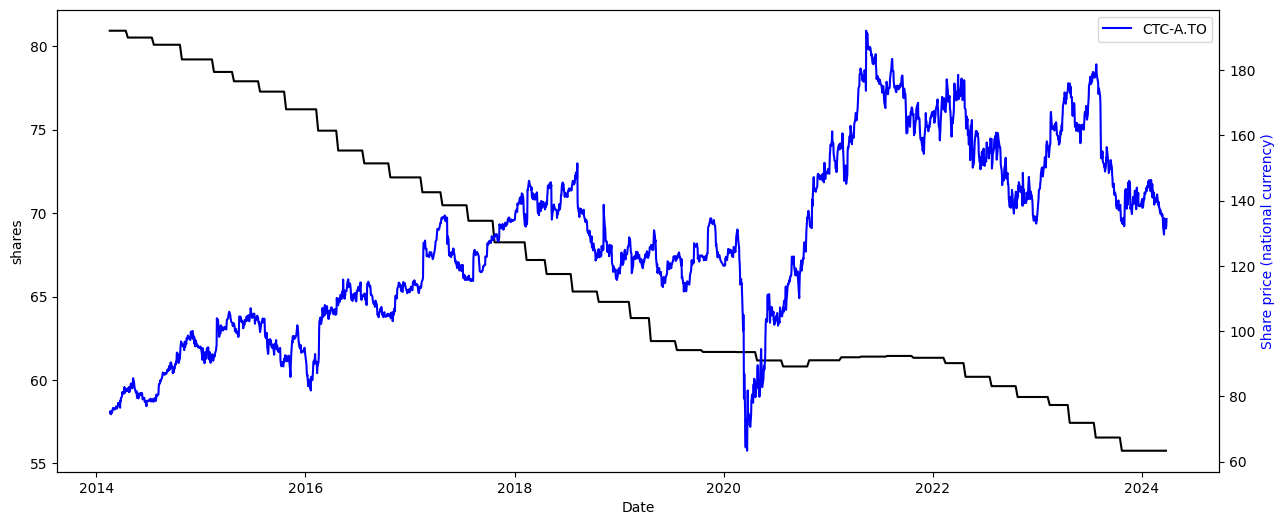

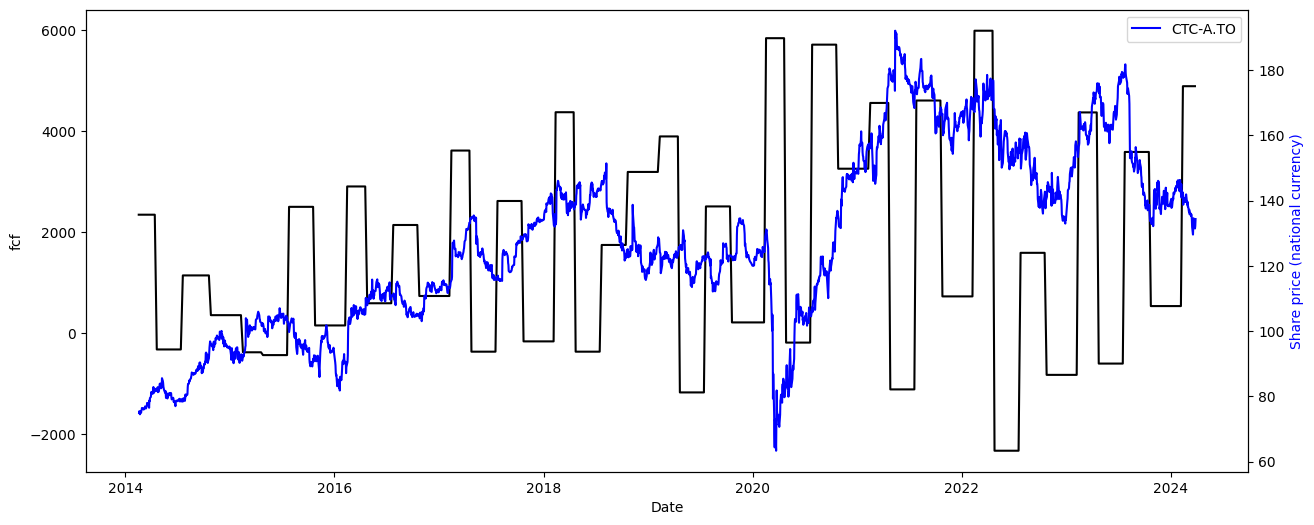

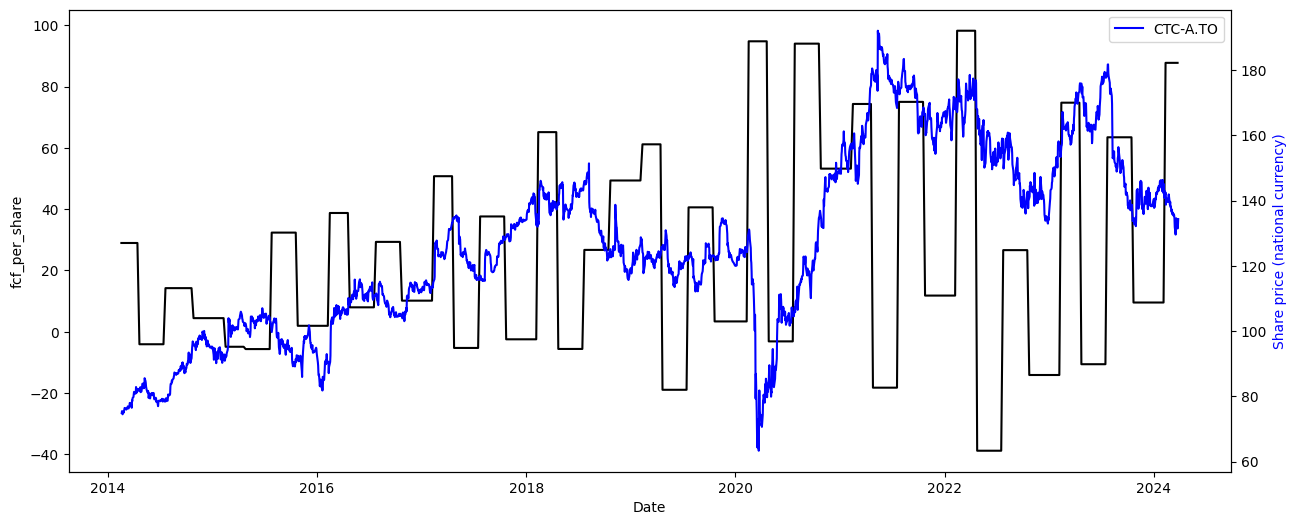

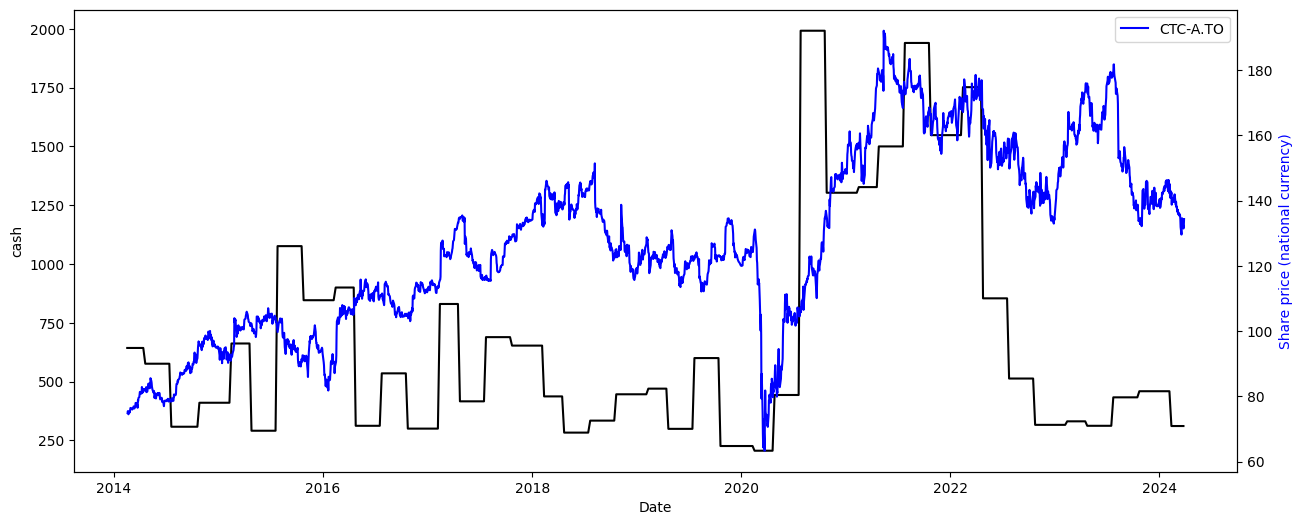

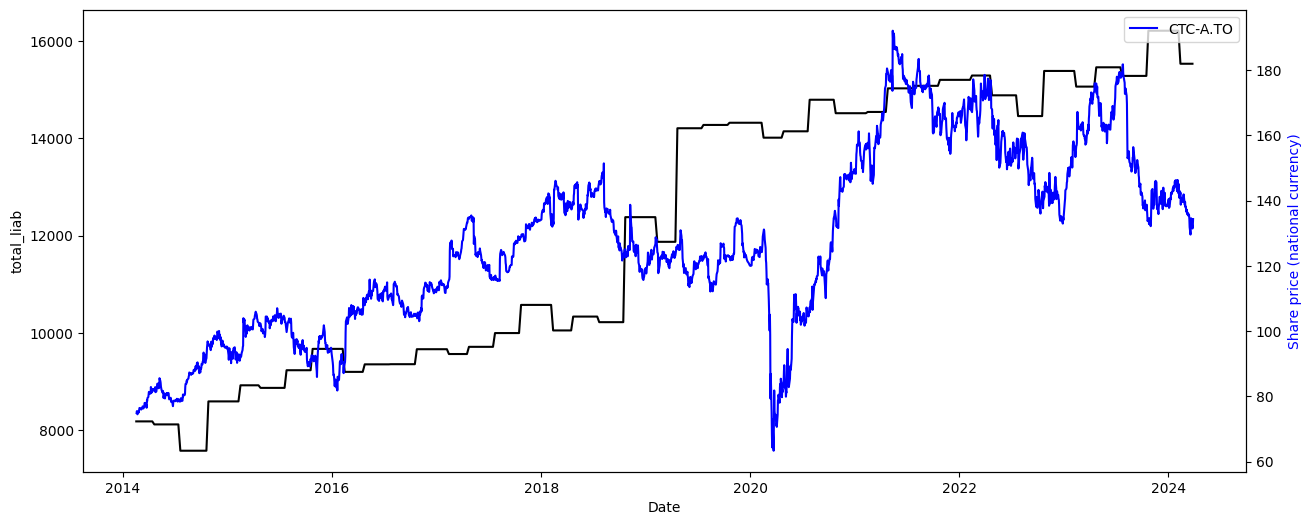

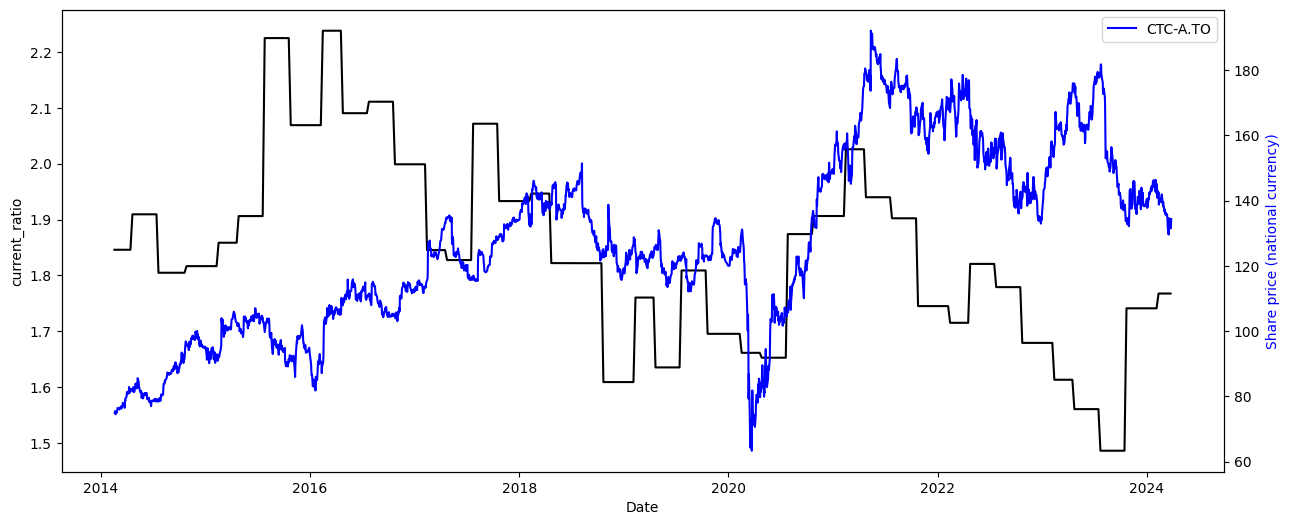

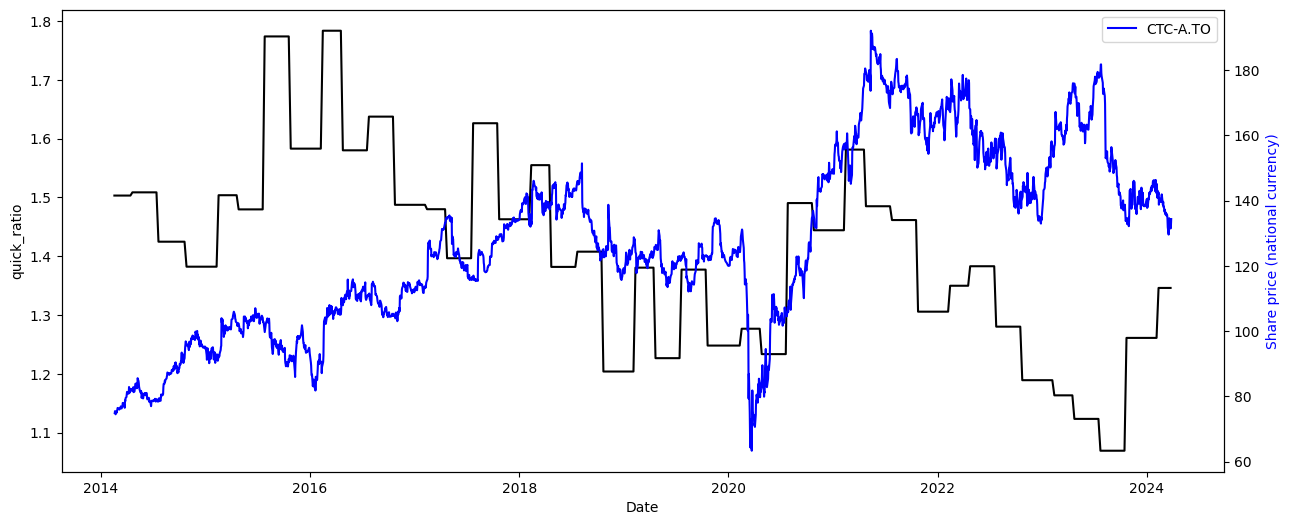

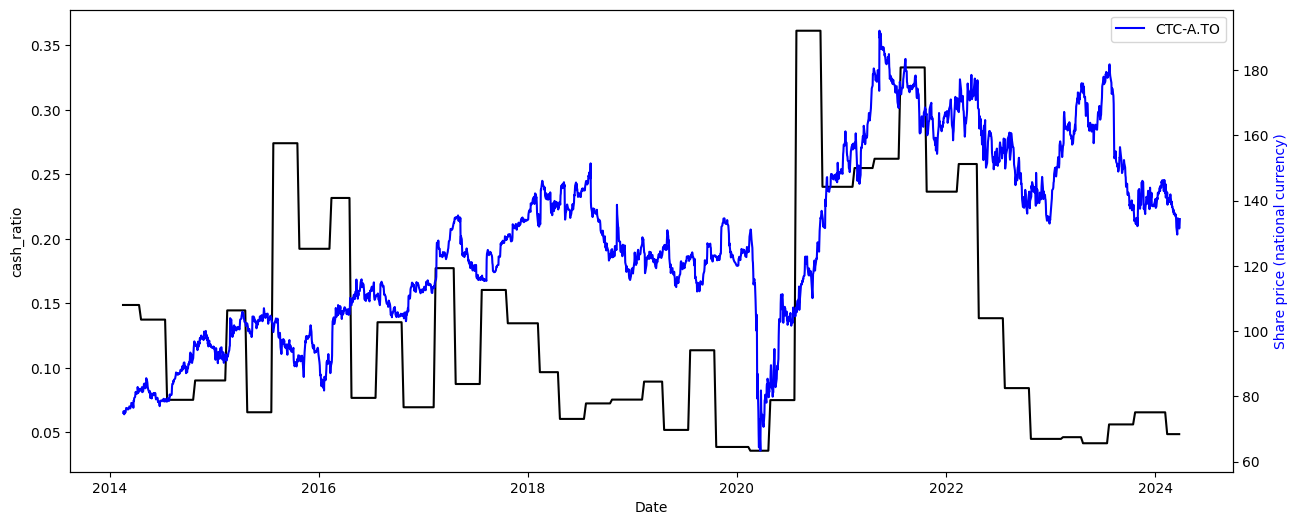

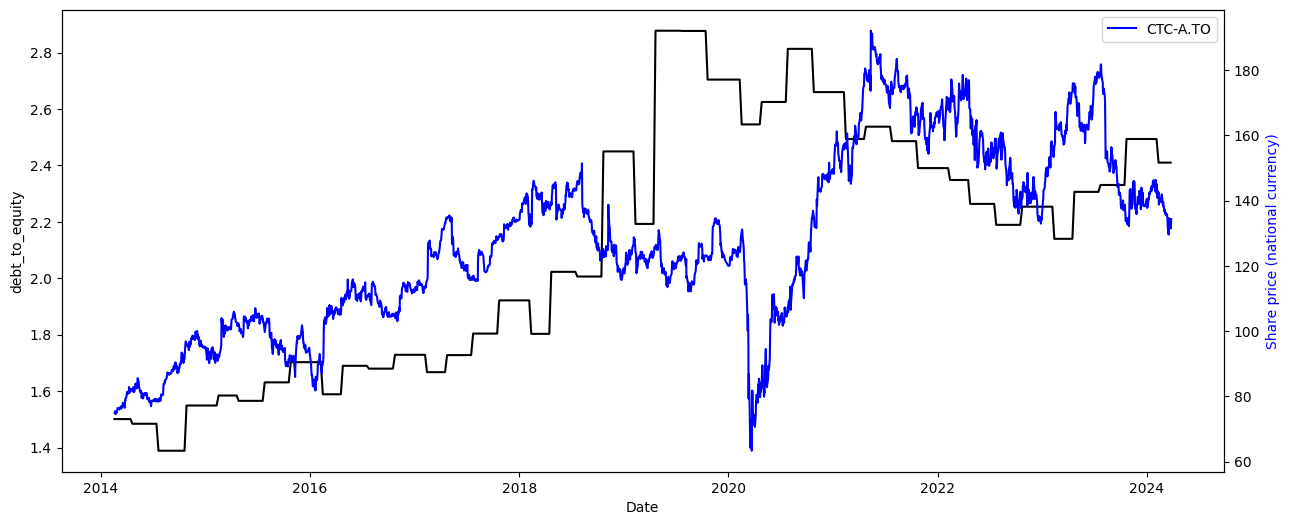

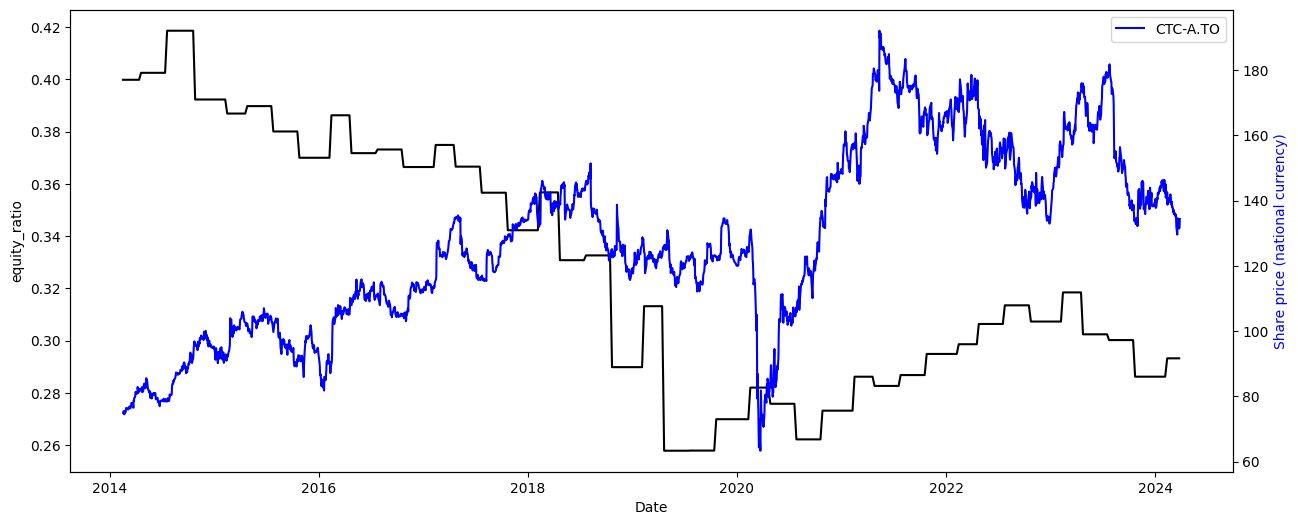

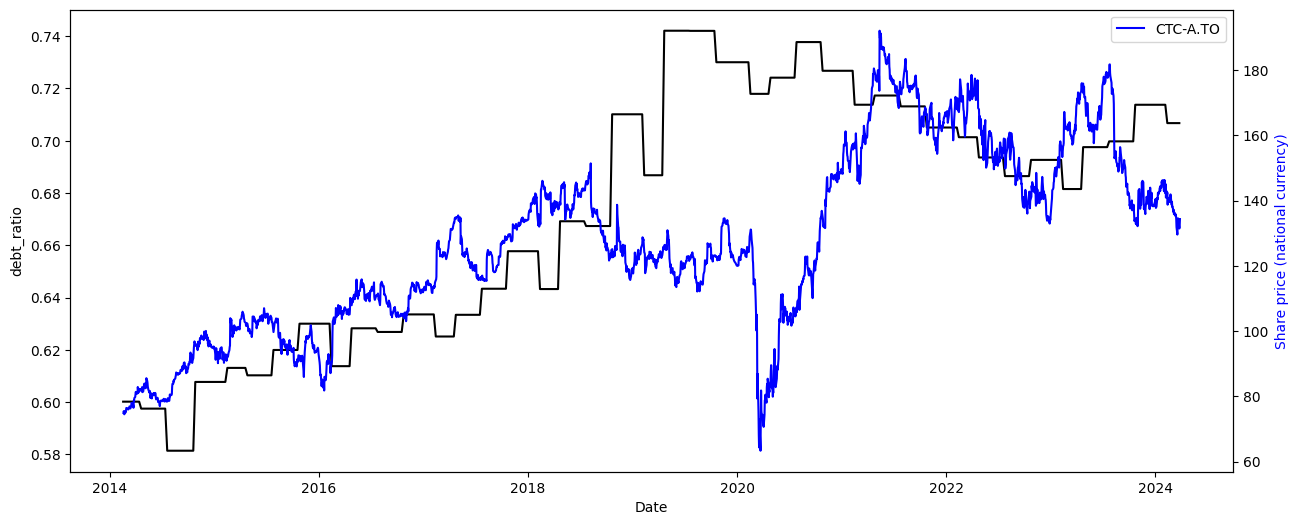

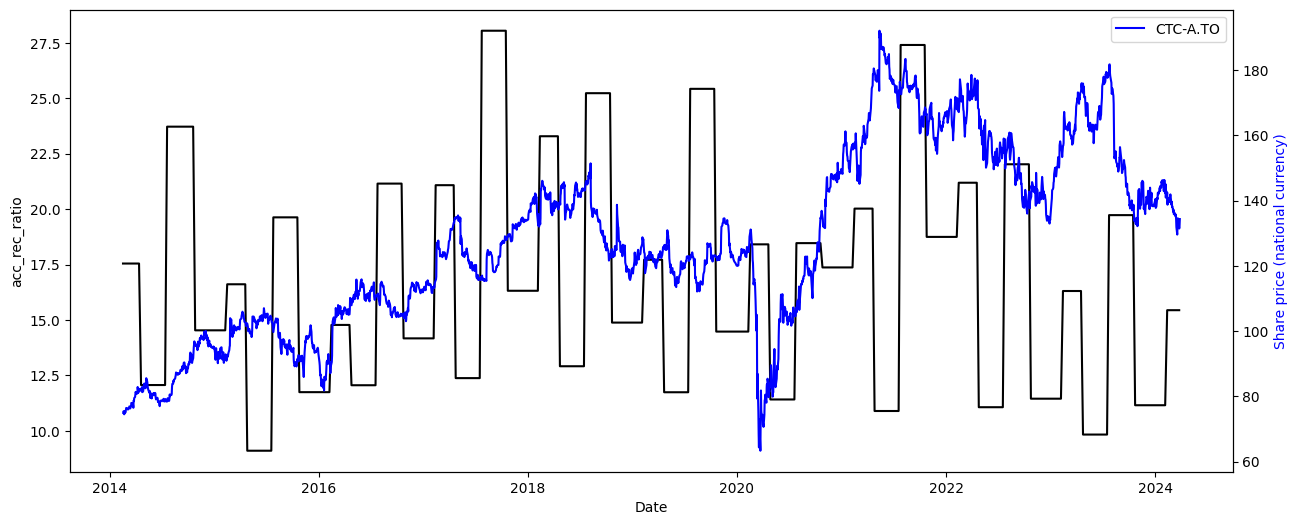

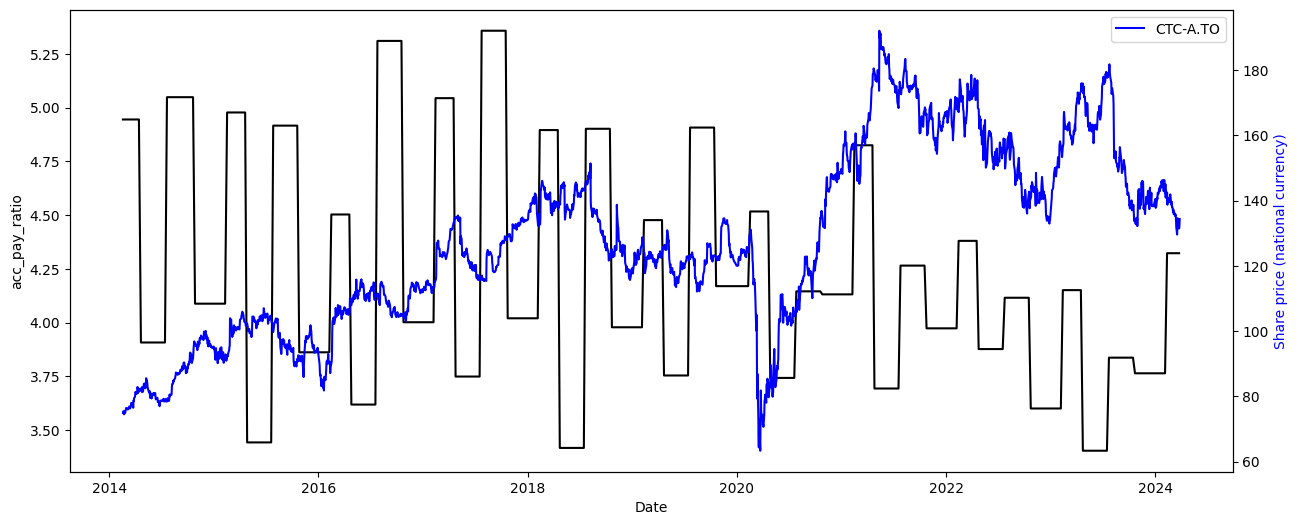

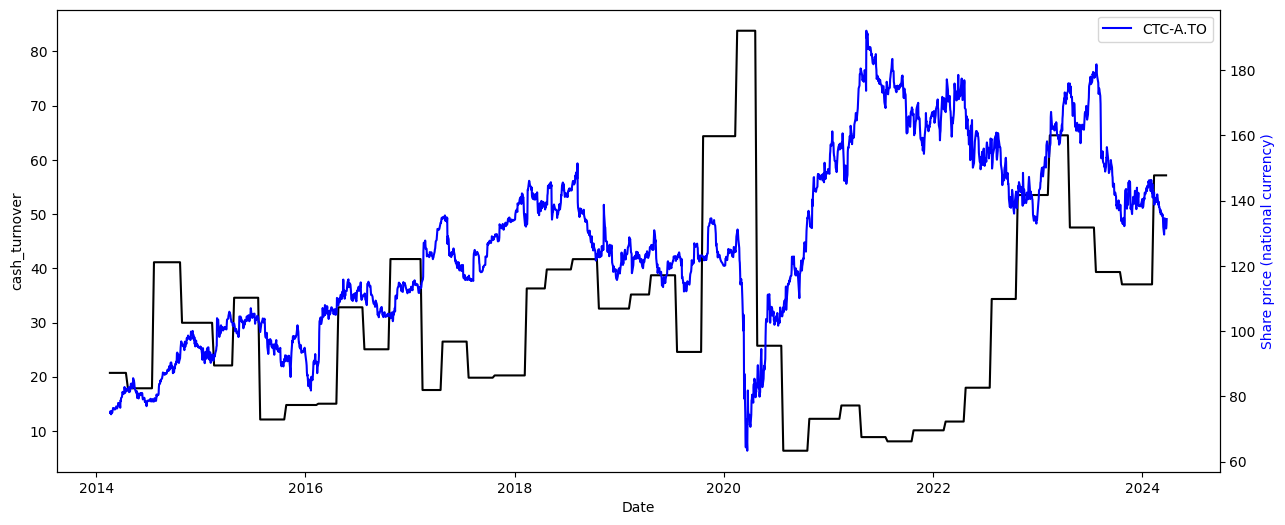

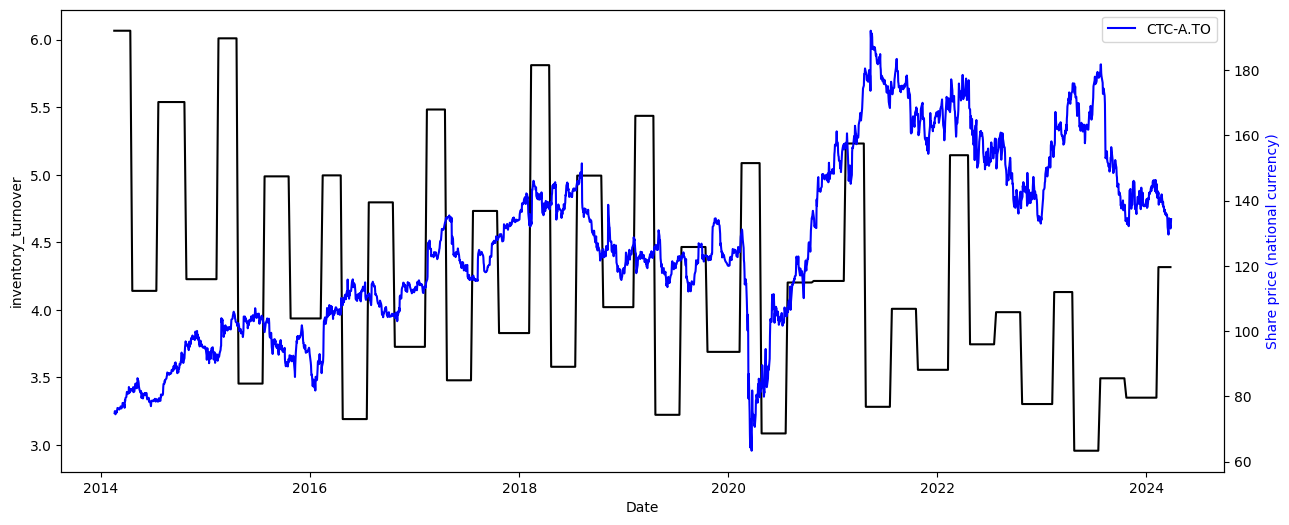

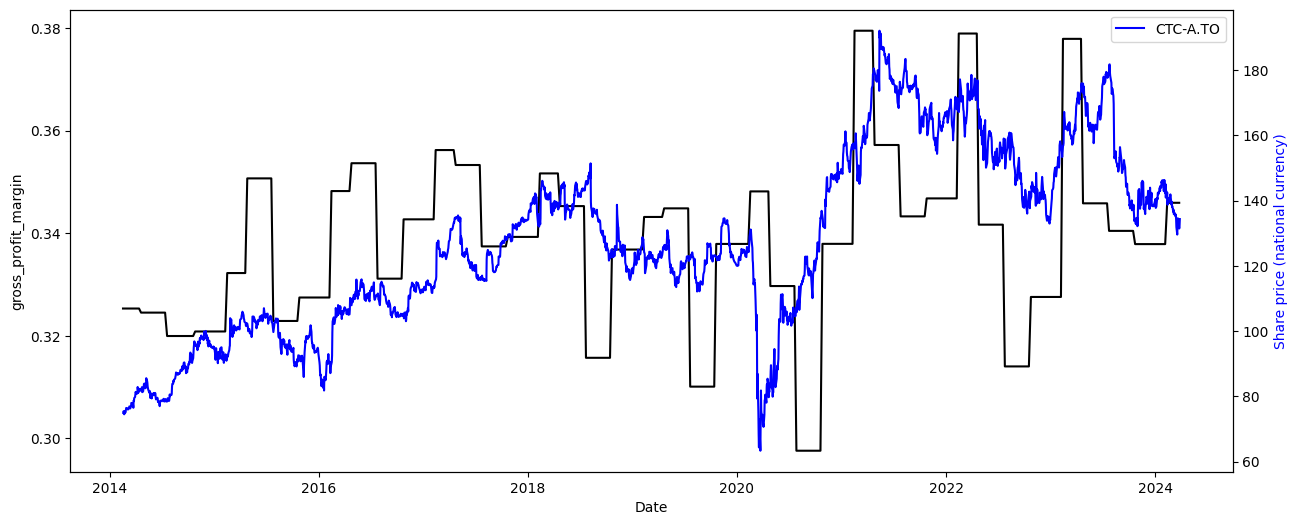

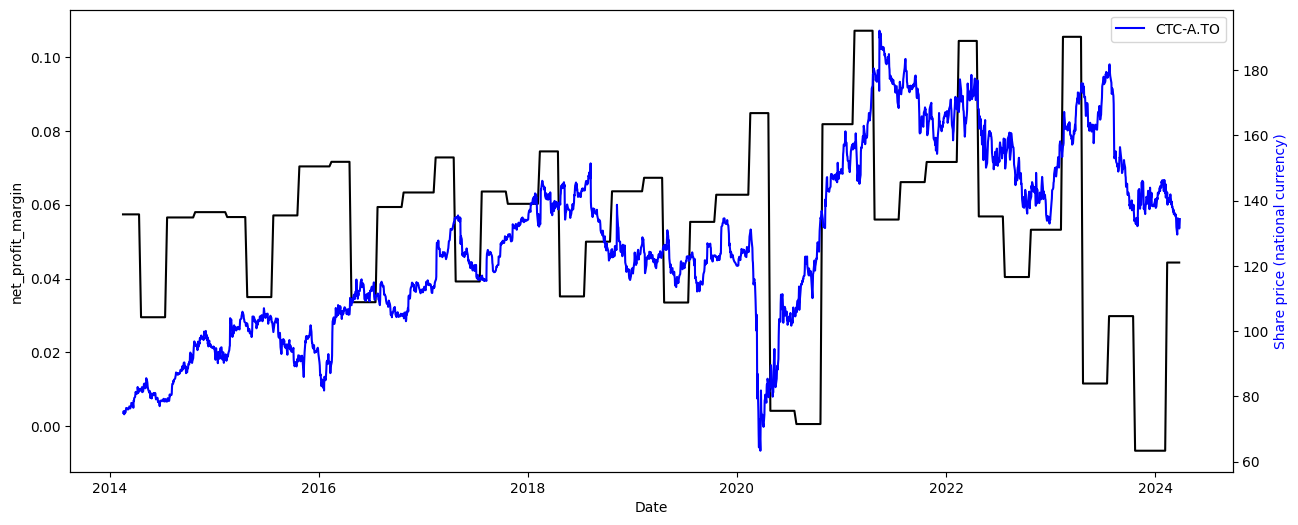

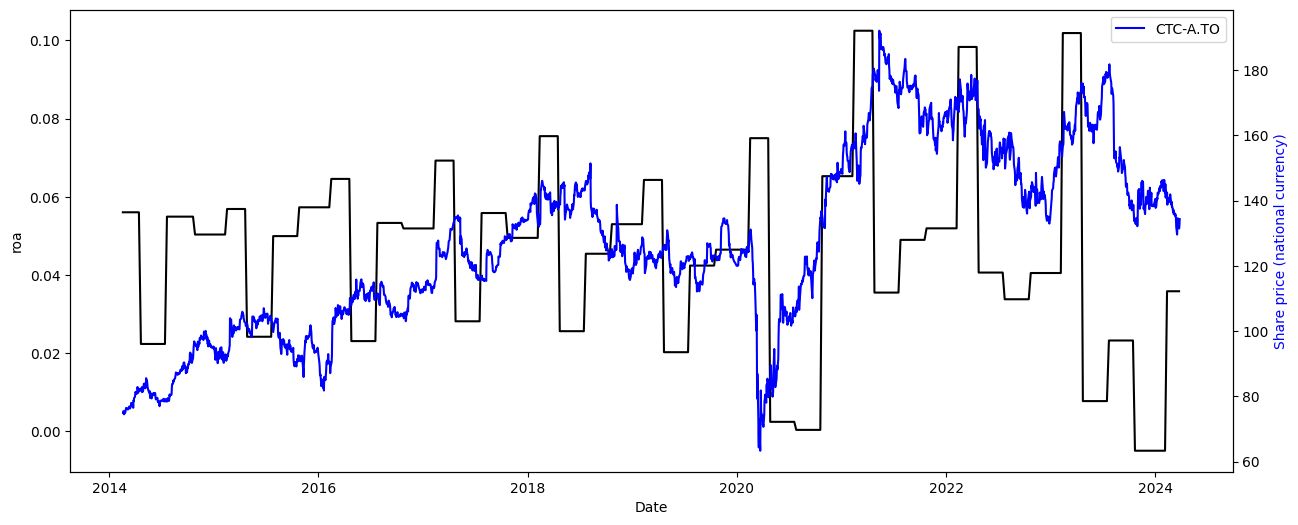

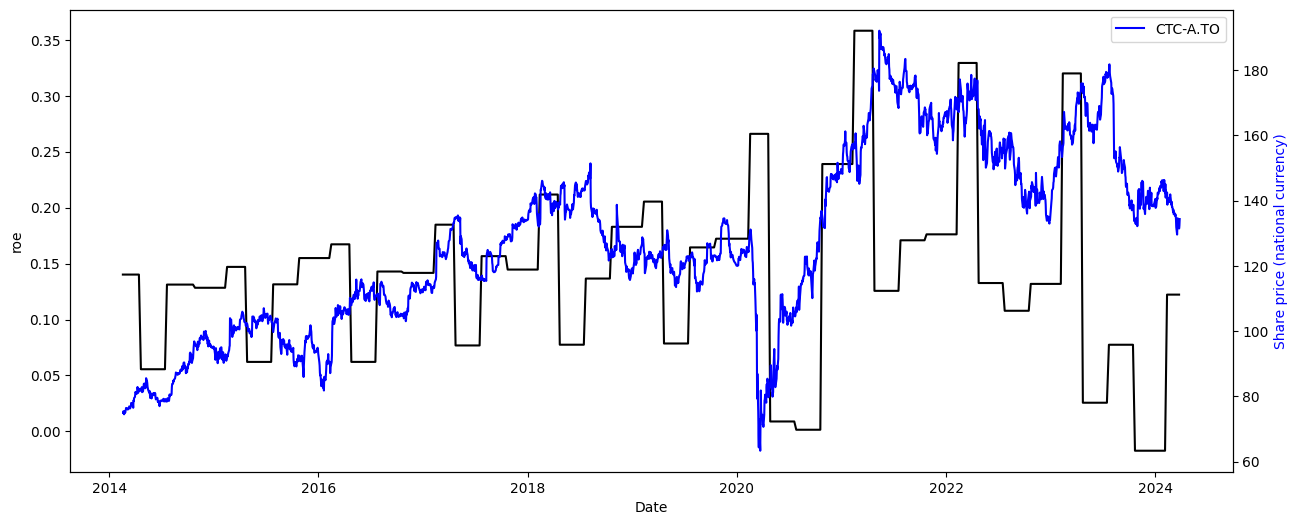

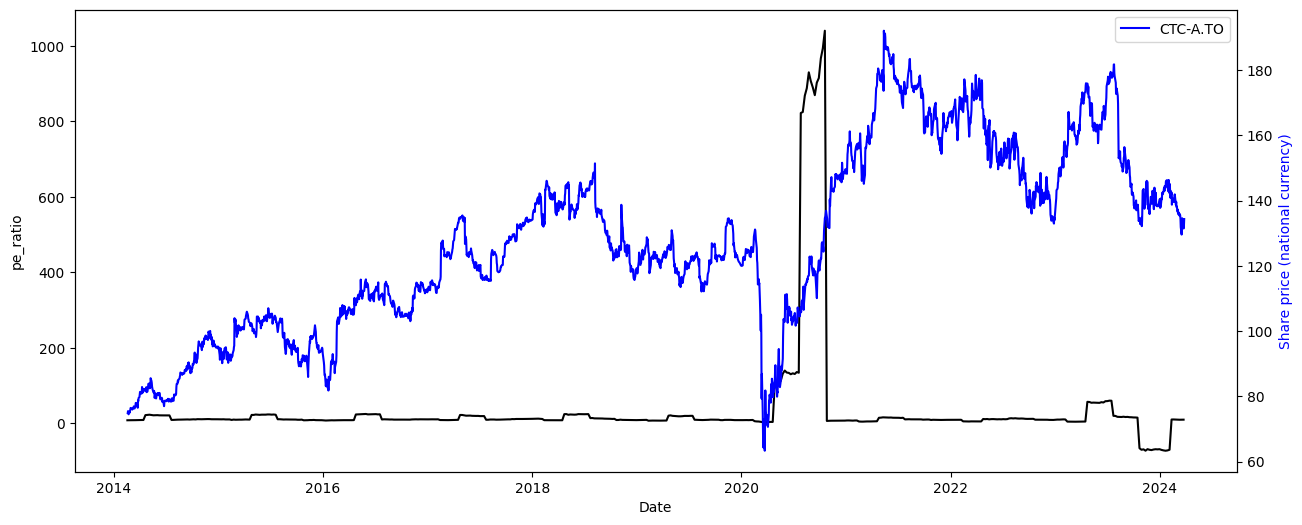

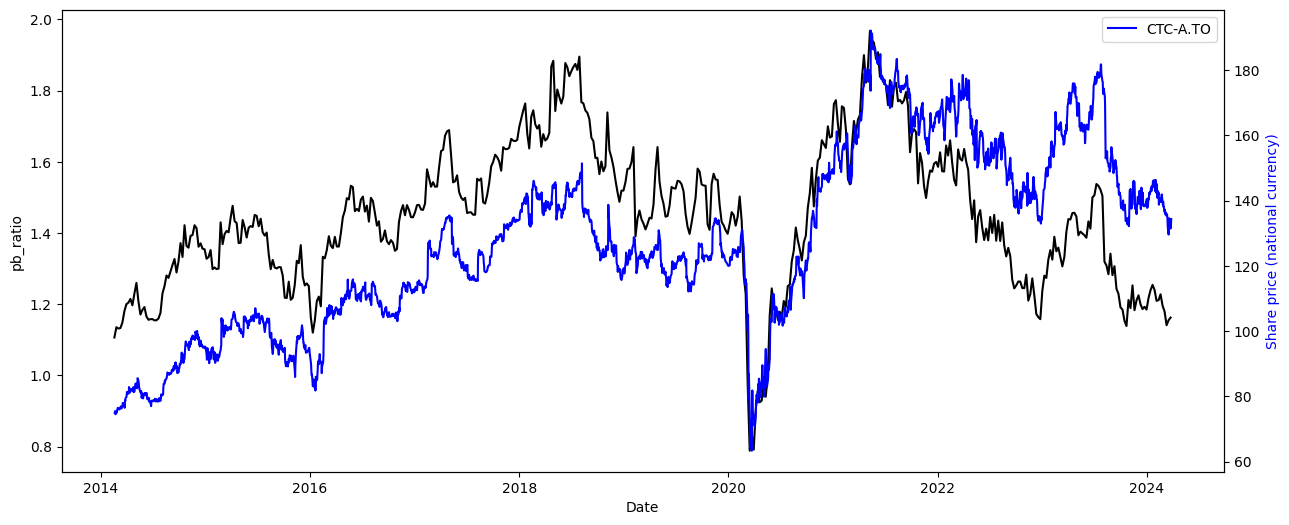

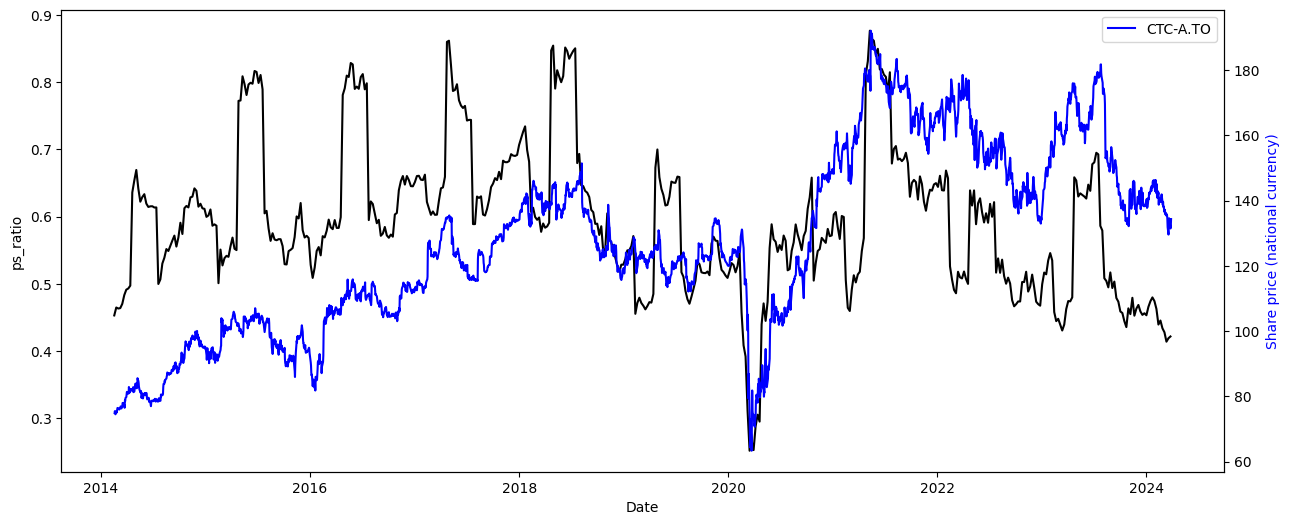

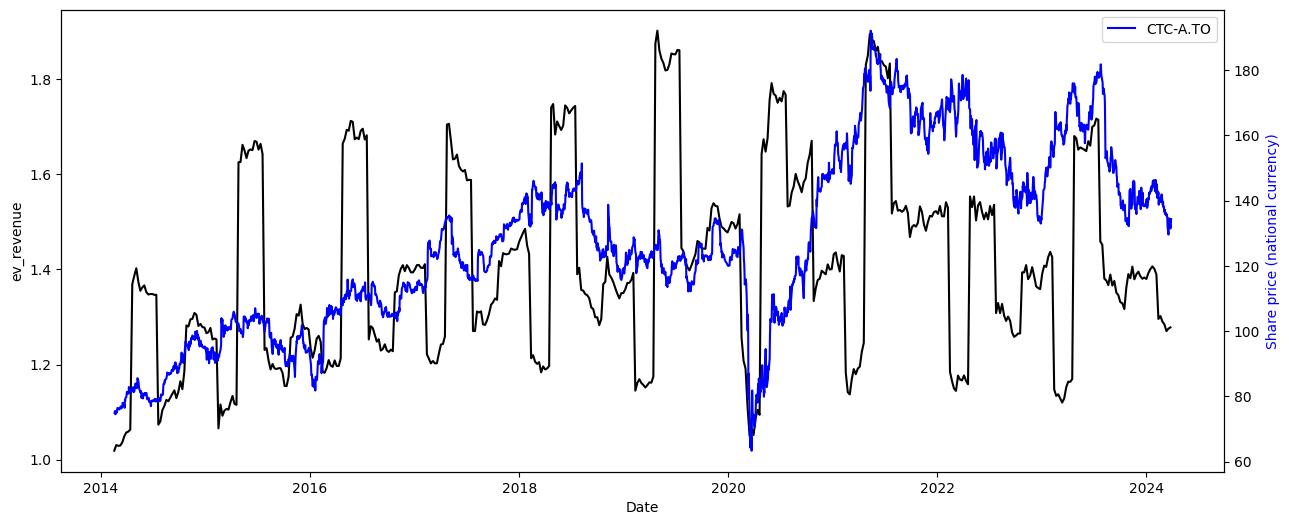

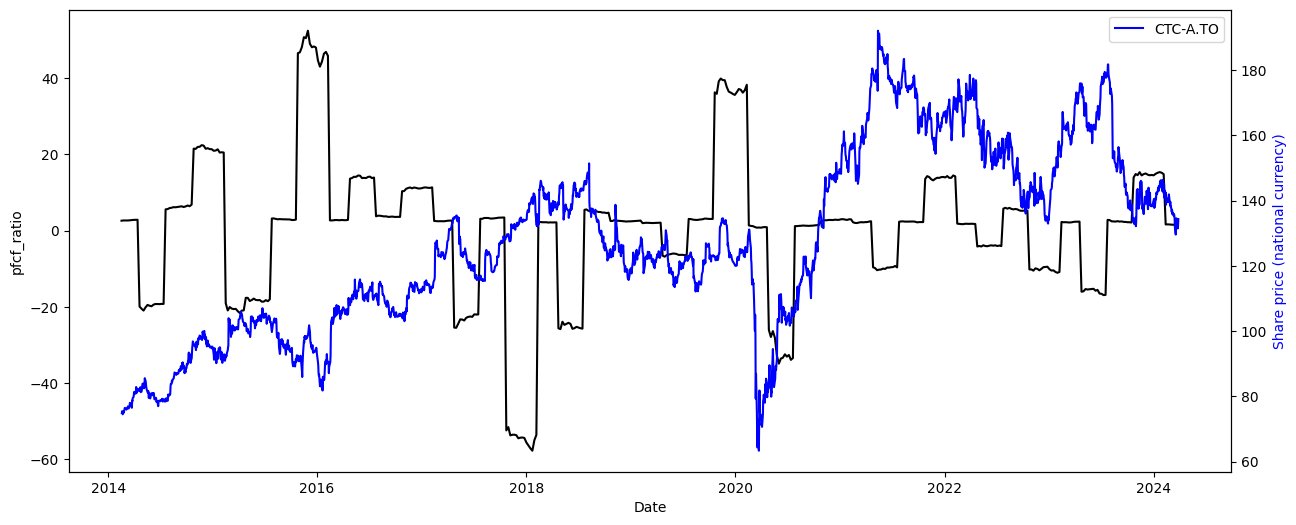

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

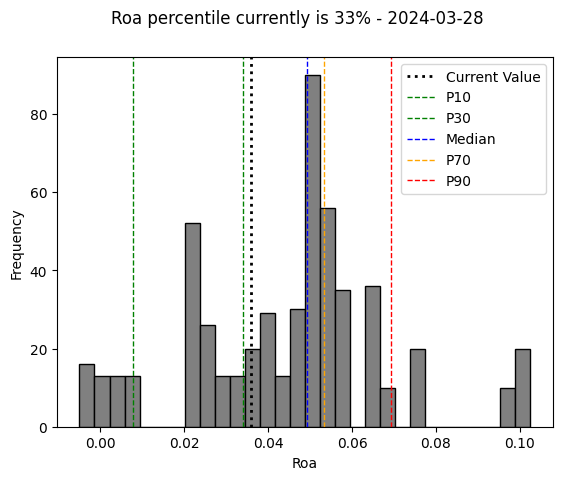

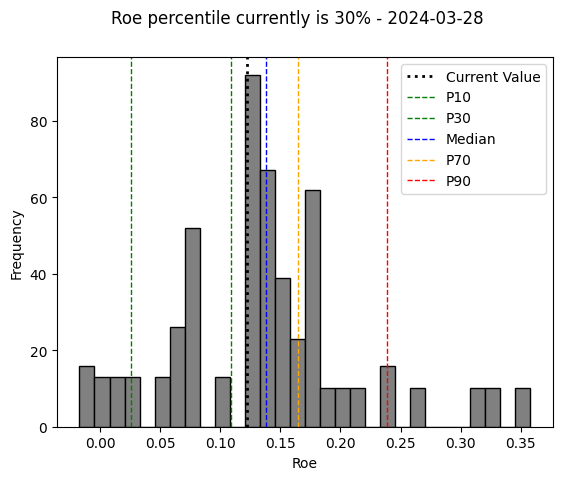

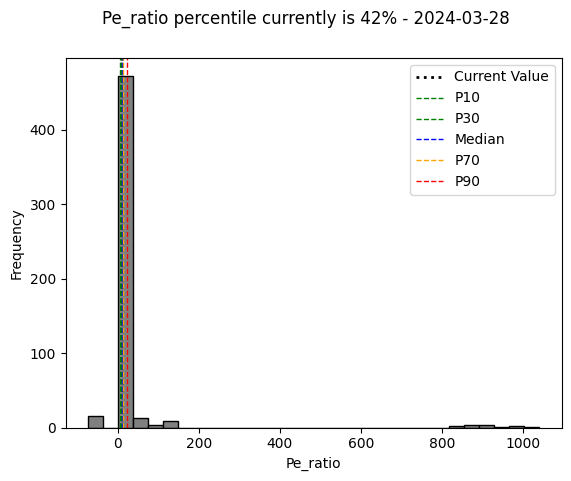

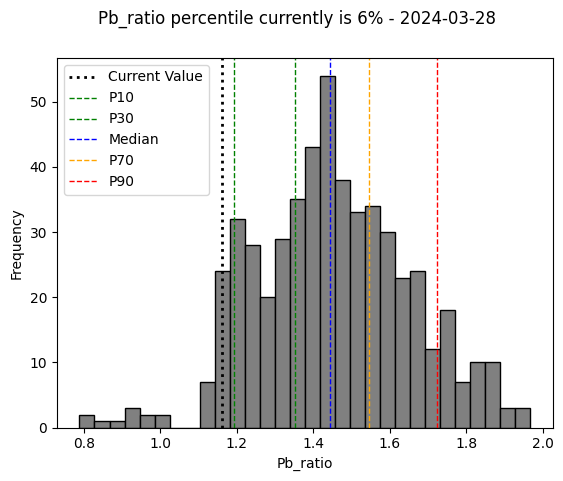

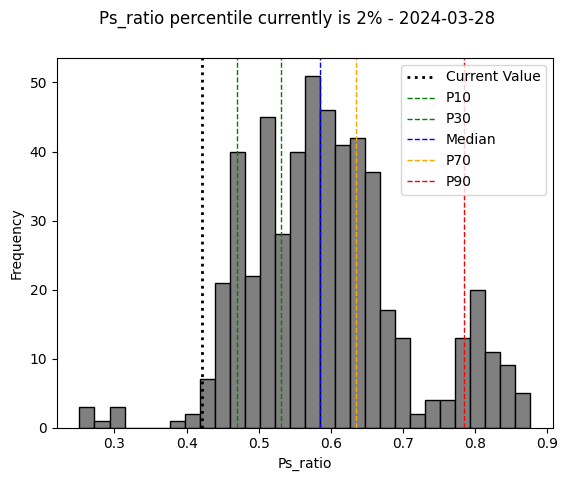

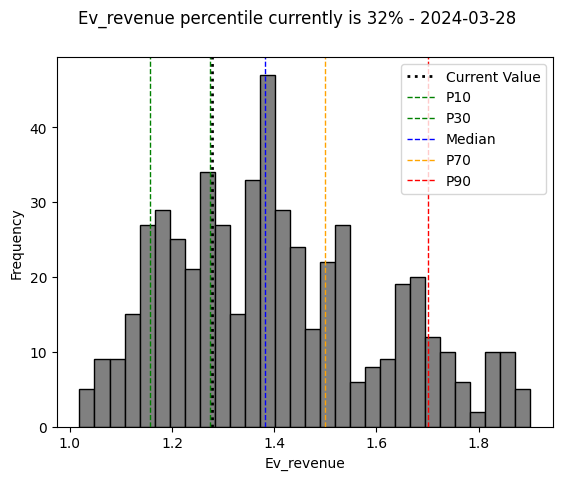

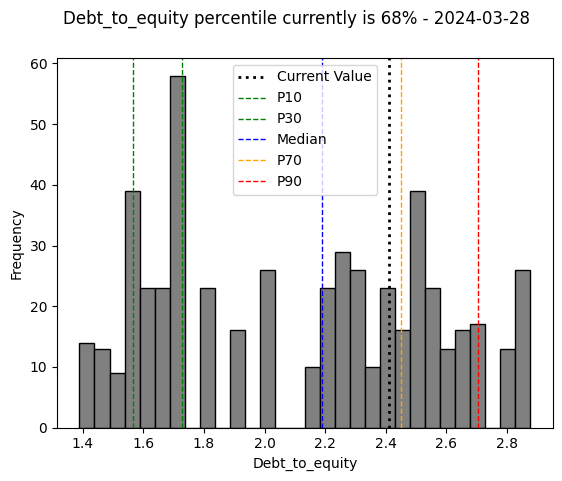

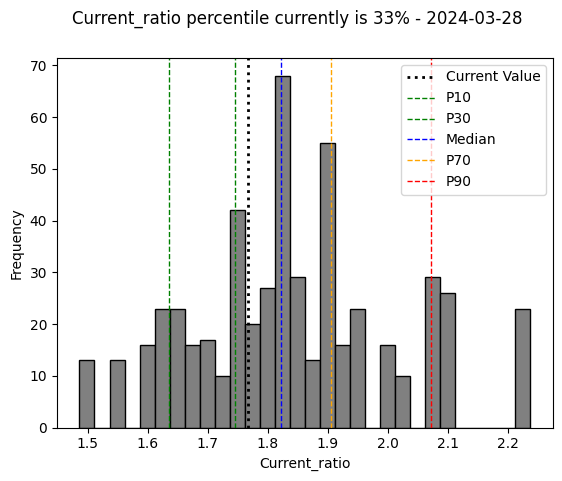

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.964830,-0.325855,0.220798,-0.279405,-0.660775,-0.183128,0.219817
roe,0.964830,1.000000,-0.305600,0.279245,-0.318411,-0.545207,0.058658,0.091545
pe_ratio,-0.325855,-0.305600,1.000000,-0.052946,0.016298,0.209880,0.252141,0.007198
pb_ratio,0.220798,0.279245,-0.052946,1.000000,0.629502,0.357410,0.162897,0.142640
ps_ratio,-0.279405,-0.318411,0.016298,0.629502,1.000000,0.666538,-0.269608,0.320144
ev_revenue,-0.660775,-0.545207,0.209880,0.357410,0.666538,1.000000,0.407556,-0.184383
debt_to_equity,-0.183128,0.058658,0.252141,0.162897,-0.269608,0.407556,1.000000,-0.520552
current_ratio,0.219817,0.091545,0.007198,0.142640,0.320144,-0.184383,-0.520552,1.000000


36 timestemos have been found!


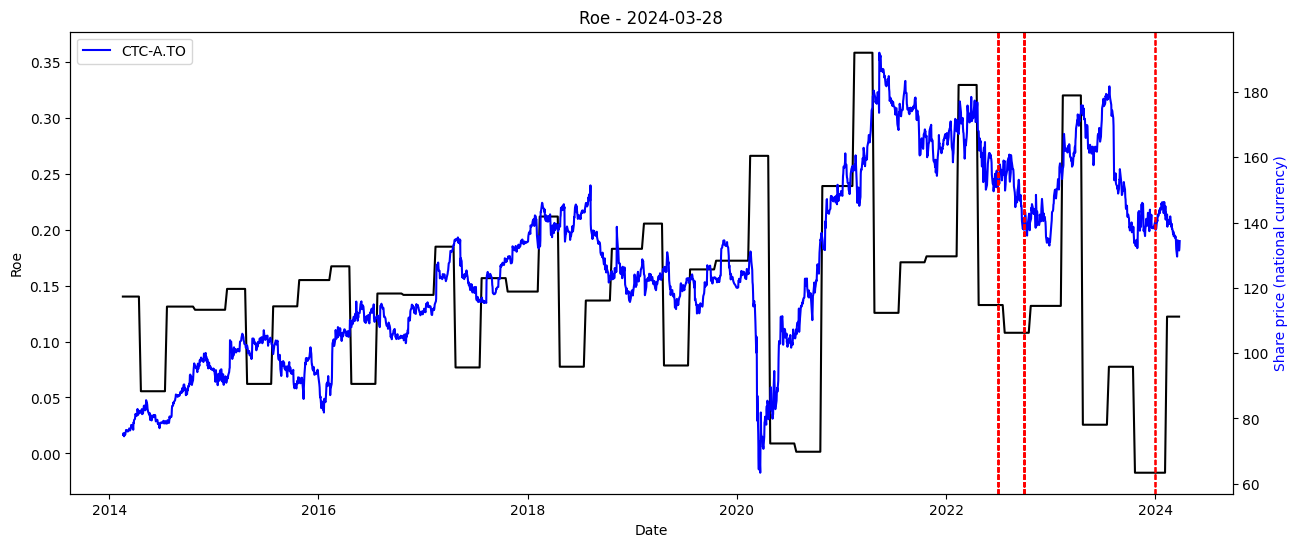

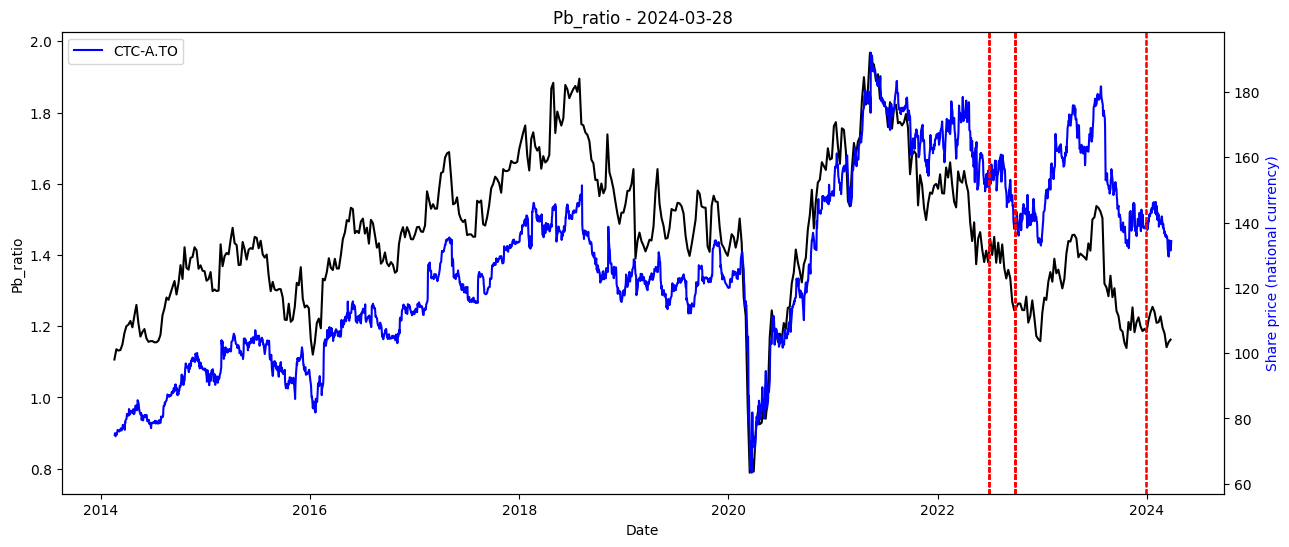

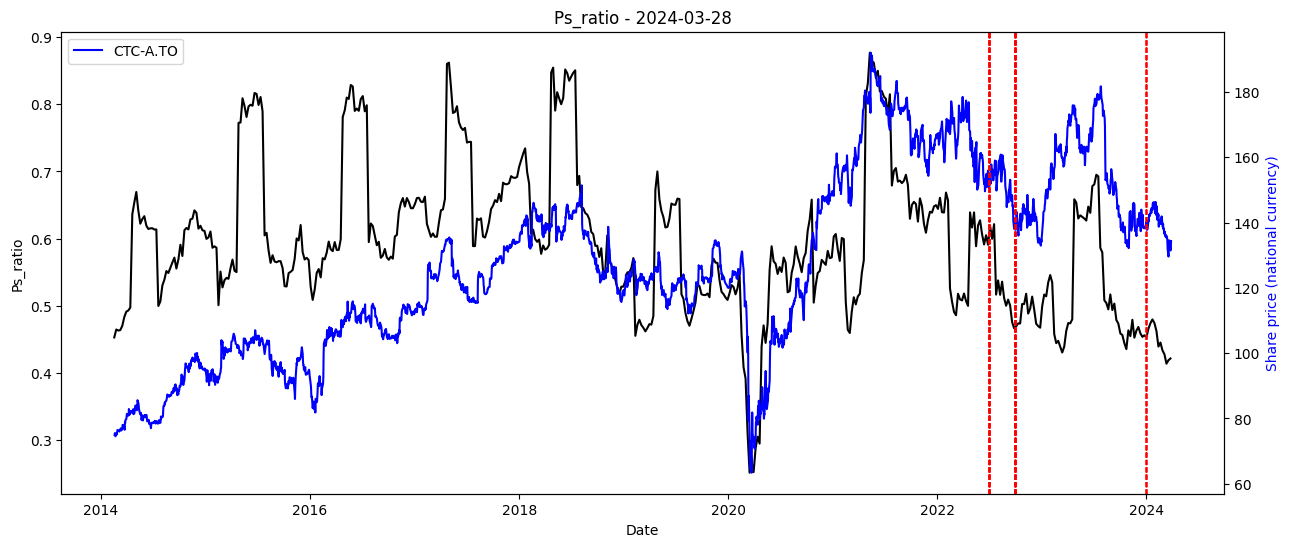

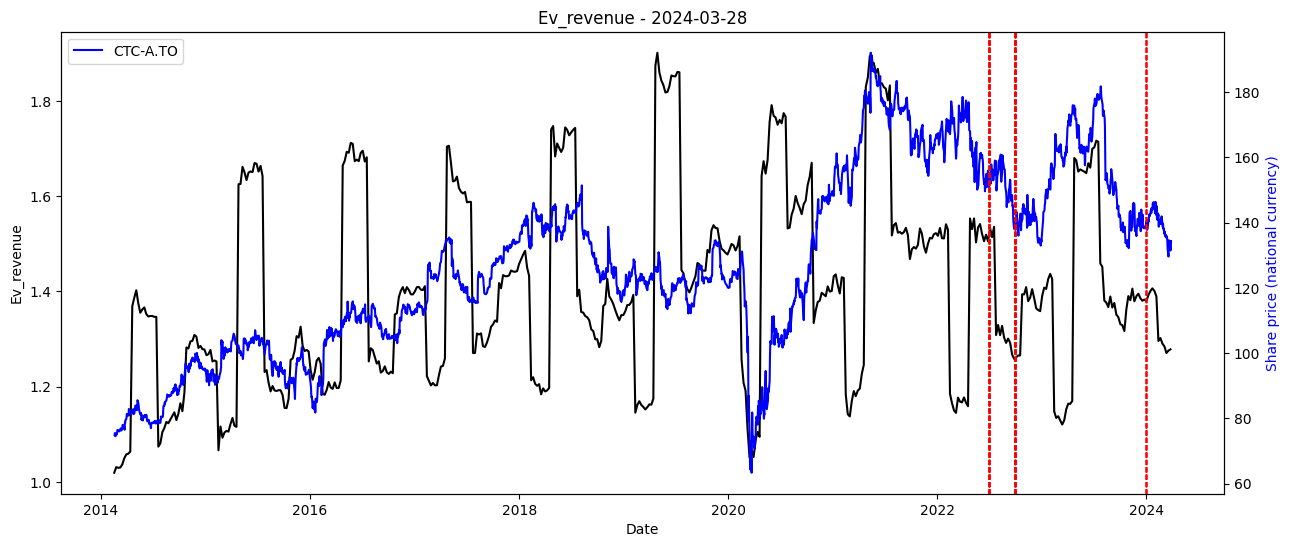

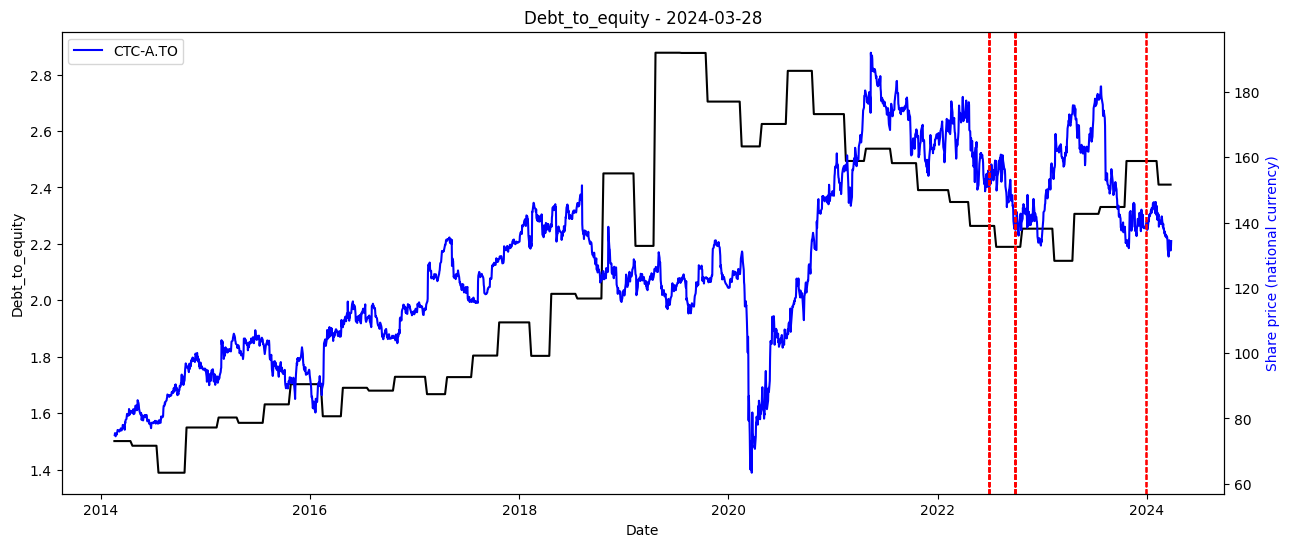

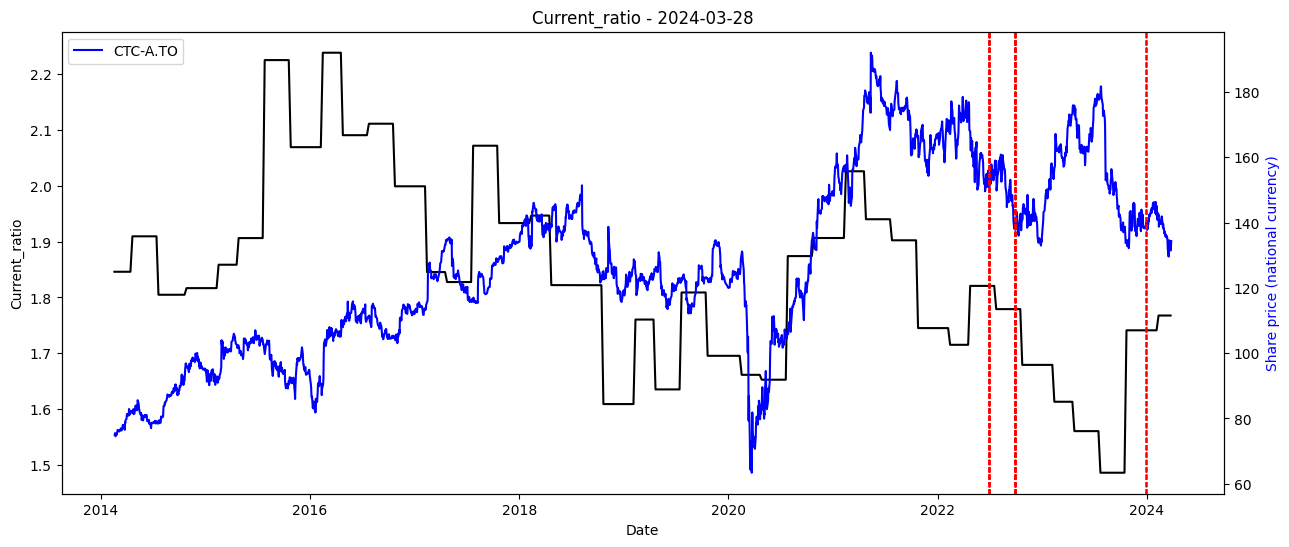

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )